In [1]:
import numpy as np
import matplotlib.pyplot as plt
from loadmodules import *
import re

%matplotlib inline

In [10]:
dir_lvl4 = './Auriga_SC/K12_fiducial/halo_6/'
dir_lvl5 = './compare_comp_time/Au6_lvl5_ec9e_10myr/output/'

In [11]:
def hubble_function(s, a):
    if s.cosmo:
        hubble_a = s.cosmo.OmegaMatter / (a * a * a) + (1 - s.cosmo.OmegaMatter - s.cosmo.OmegaLambda) / (a * a)  + s.cosmo.OmegaLambda
        hubble_a = s.cosmo.HubbleConst * np.sqrt(hubble_a)
        return a*hubble_a
    else:
        return None

In [12]:
timesteps = []
a_list = []
for dir in [dir_lvl4, dir_lvl5]:
    s = gadget_readsnap(127, dir, onlyHeader=True)
    unit_time_in_sec = s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s
    sec_per_myr = 3.15576e13
    
    with open(dir + 'timebins.txt', 'r') as f:
        data = f.read()
    
    blocks = re.split(r'(?=Sync-Point)', data)
    
    timesteps_lvl = []
    a_list_lvl = []
    
    for block in blocks:
        time_match = re.search(r'Time:\s*([0-9.eE+-]+)', block)
        if not time_match:
            continue
        time = float(time_match.group(1))
    
        dt_list = re.findall(r'\sbin=\d+\s+\d+\s+\d+\s+([0-9.eE+-]+)', block)
        for dt in dt_list:
            dt = float(dt)
            a_list_lvl.append(time)
            timesteps_lvl.append(dt * time / hubble_function(s,time) * unit_time_in_sec / sec_per_myr / s.hubbleparam)
    
    timesteps_lvl = np.array(timesteps_lvl)
    a_list_lvl = np.array(a_list_lvl)
    timesteps.append(timesteps_lvl)
    a_list.append(a_list_lvl)

In [13]:
for steps in timesteps:
    print(steps.min(), steps.max(), steps.mean(), steps.std(), np.median(steps))

0.0011325887212507875 8.54560846117562 0.9808100135999883 1.9154449889749616 0.12974164213900324
0.004793928288838971 4.793284483288234 0.820575186725325 1.1279779394388822 0.215475131085118


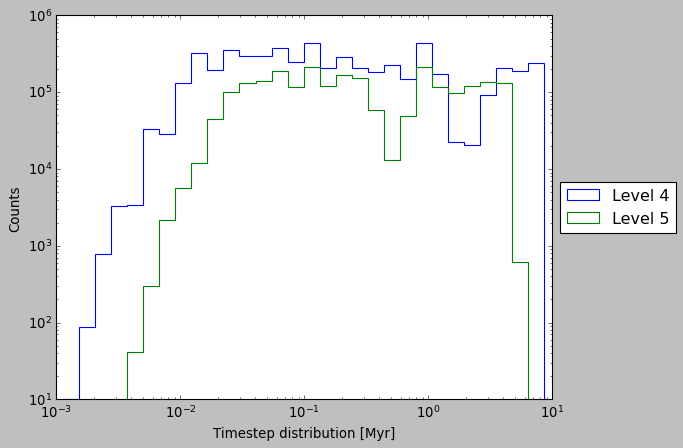

In [14]:
logbins = np.logspace(np.log10(timesteps[0].min()), np.log10(timesteps[0].max()), 31)
plt.hist(timesteps[0], bins=logbins, histtype='step', label='Level 4')
plt.hist(timesteps[1], bins=logbins, histtype='step', label='Level 5')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Timestep distribution [Myr]')
plt.ylabel('Counts')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

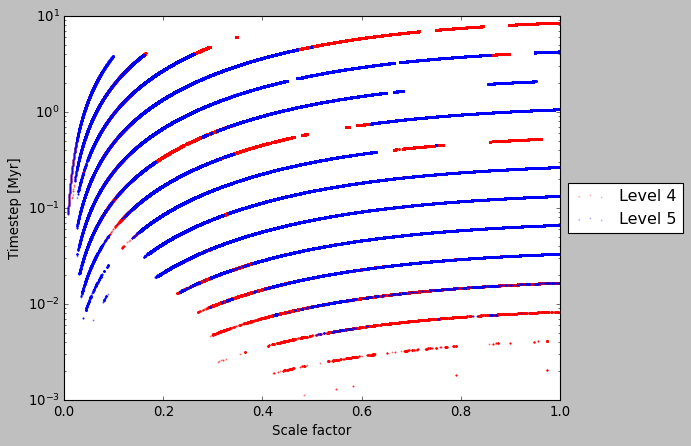

In [16]:
plt.scatter(a_list[0], timesteps[0], s=0.5, alpha=0.25, edgecolor='face', c='r', label='Level 4')
plt.scatter(a_list[1], timesteps[1], s=0.5, alpha=0.25, edgecolor='face', c='b', label='Level 5')
plt.yscale('log')
plt.xlabel('Scale factor')
plt.ylabel('Timestep [Myr]')
plt.xlim(0, 1)
plt.ylim(1e-3, 1e1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.020174969732761384
Found 1456664 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
galrad= 0.019006030261516572
Found 71233 stars.
Rotated pos.
Rotated bfld.
Rotated vel.


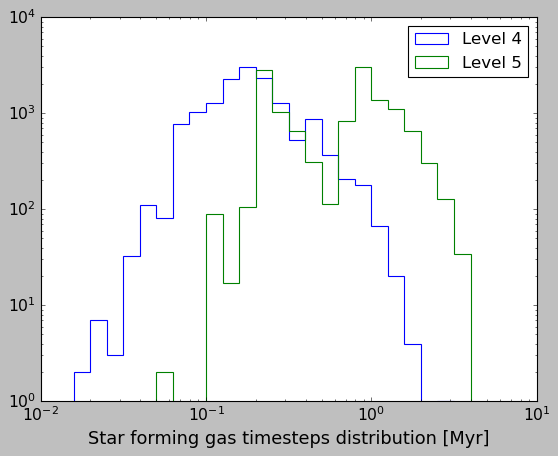

In [2]:
sim_lvl4 = './Au6_lvl4_814c_tview/output/'
sim_lvl5 = './compare_comp_time/Au6_lvl5_814c_tview/output/'
sims = [sim_lvl4, sim_lvl5]
snaps = [116, 127]
labels = ['Level 4', 'Level 5']
sec_per_myr = 3.15576e13

logbins = np.logspace(-2,1, 31)
for i, sim in enumerate(sims):
    sf = load_subfind(snaps[i], dir=sim, hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
    s = gadget_readsnap(snaps[i], snappath=sim, subfind=sf, hdf5=True, loadonlyhalo=0)
    s.calc_sf_indizes( sf )
    galrad = 0.1 * sf.data['frc2'][0]
    s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

    plt.hist(s.data['tcfe'][s.data['tcfe'] > 0.]/sec_per_myr, bins=logbins, label=labels[i], histtype='step')

plt.legend(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Star forming gas timesteps distribution [Myr]', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)